In [1]:
# Configure for Platform
import os
from pathlib import Path
import sys

if Path("/kaggle").exists():
    platform = "kaggle"
    sys.path.append("/kaggle/input/sicheng-ml-lib")
    OUTPUT_DIR = Path("/kaggle/working/")
else:
    platform = "local"
    os.environ["KERAS_BACKEND"] = "jax"
    OUTPUT_DIR = Path("../../output/")
print(f"the platform is {platform}")

the platform is local


In [2]:
# Init Environment
import pandas as pd
import matplotlib.pyplot as plt
from mylib import post_plot, iskaggle

IMG_DIR = OUTPUT_DIR / "imgs"
MODEL_DIR = OUTPUT_DIR / "model"

IMG_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", figsize=(30, 6))
plt.rc("axes", labelweight="bold", labelsize="large", titlesize=16, titlepad=10)

In [3]:
# Important arguments
plot_kw = dict(show=True, save=True, img_dir=IMG_DIR / "lstm")
# data size
N = 1 * 60 * 60 * 24  # 1 day
window_pre = 3 * 60  # 1 mins
window_post = 1  # 1 s
test_rate = 0.2
# super arguments
epochs = 1
batch_size = 1024
dropout_rate = 0.2
# train or load
TRAIN = iskaggle()

In [4]:
# load dataset
from mylib.new_energy_plant import DataSet

dfs = [ds.load_dataframe() for ds in DataSet]
print(dfs[0].head())

                value
738911257.0  0.569018
738911258.0  0.569091
738911259.0  0.569127
738911260.0  0.568845
738911261.0  0.568736


In [5]:
# LSTM model (fit or load)
import keras
from numpy.lib.stride_tricks import sliding_window_view
from mylib.models.lstm import SimpleLSTMRegression


def get_models_and_data(dfs, train=True):
    models = []
    X_trains, X_tests, y_trains, y_tests = [], [], [], []

    for ds, df in zip(DataSet, dfs):
        ts = df.iloc[-N:, 0]
        data = sliding_window_view(ts, window_shape=window_post + window_pre)
        X, y = data[:, :window_pre], data[:, window_pre:]
        X = X.reshape((X.shape[0], window_pre, -1))
        test_size = int(X.shape[0] * (1 - test_rate))
        X_train, X_test = X[:test_size], X[test_size:]
        y_train, y_test = y[:test_size], y[test_size:]

        X_trains.append(X_train)
        X_tests.append(X_test)
        y_trains.append(y_train)
        y_tests.append(y_test)
        if not train:
            lstm = keras.saving.load_model(
                MODEL_DIR / f"{ds.name}-lstm-regression.keras"
            )
            models.append(lstm)
            print(f"{lstm.name} is loaded.")
            continue
        lstm = SimpleLSTMRegression(
            input_shape=X.shape[1:],
            units=128,
            window_post=window_post,
            dropout_rate=dropout_rate,
            name=f"{ds.name}-lstm-regression",
        )
        # lstm.summary()
        lstm.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.MeanSquaredError(),
        )
        models.append(lstm)
        print(f"{lstm.name} model compile over.")
    if train:
        # fit models
        histories = []
        for model, X_train, y_train in zip(models, X_trains, y_trains):
            history = model.fit(
                X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1
            )
            histories.append(history)
            print(f"{model.name} model fitted over.")
        # save models
        for model in models:
            model.save(MODEL_DIR / f"{model.name}.keras")
    return models, X_trains, X_tests, y_trains, y_tests


models, X_trains, X_tests, y_trains, y_tests = get_models_and_data(dfs, train=TRAIN)

Solar-lstm-regression is loaded.
WindPower-lstm-regression is loaded.
WindVelocity-lstm-regression is loaded.


539/539 ━━━━━━━━━━━━━━━━━━━━ 62s 114ms/step


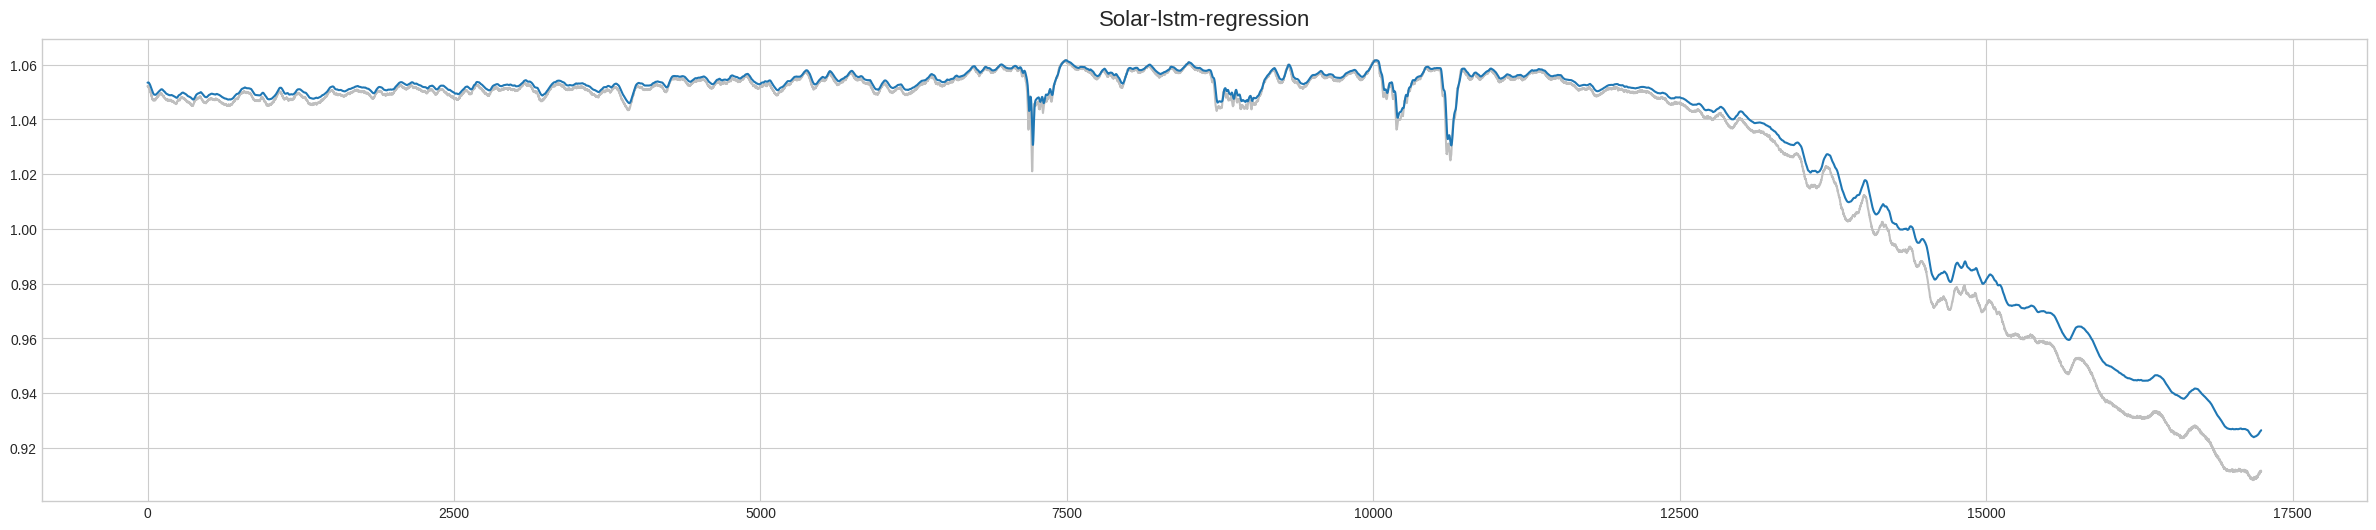

539/539 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step


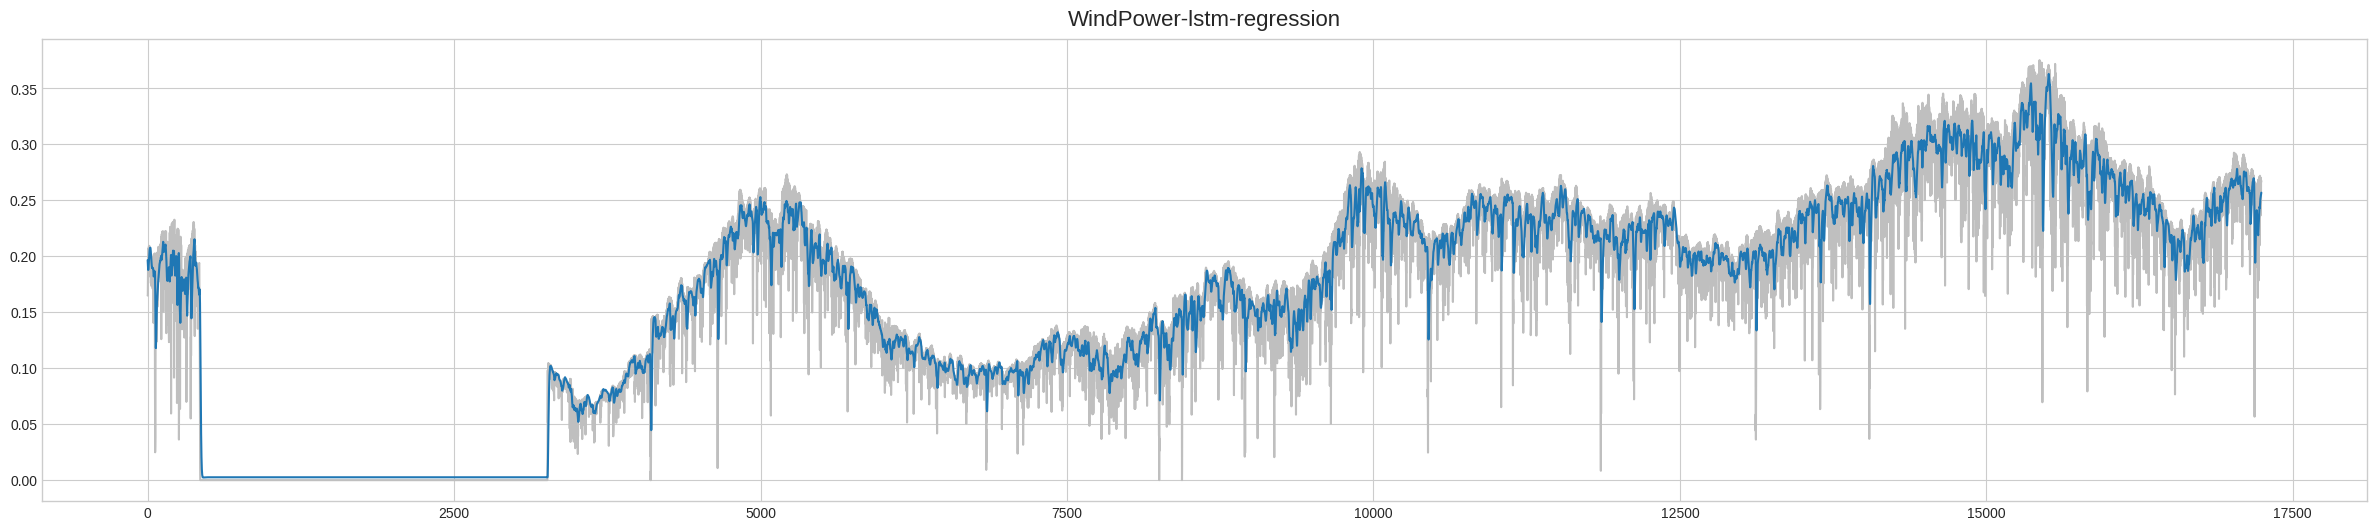

539/539 ━━━━━━━━━━━━━━━━━━━━ 67s 125ms/step


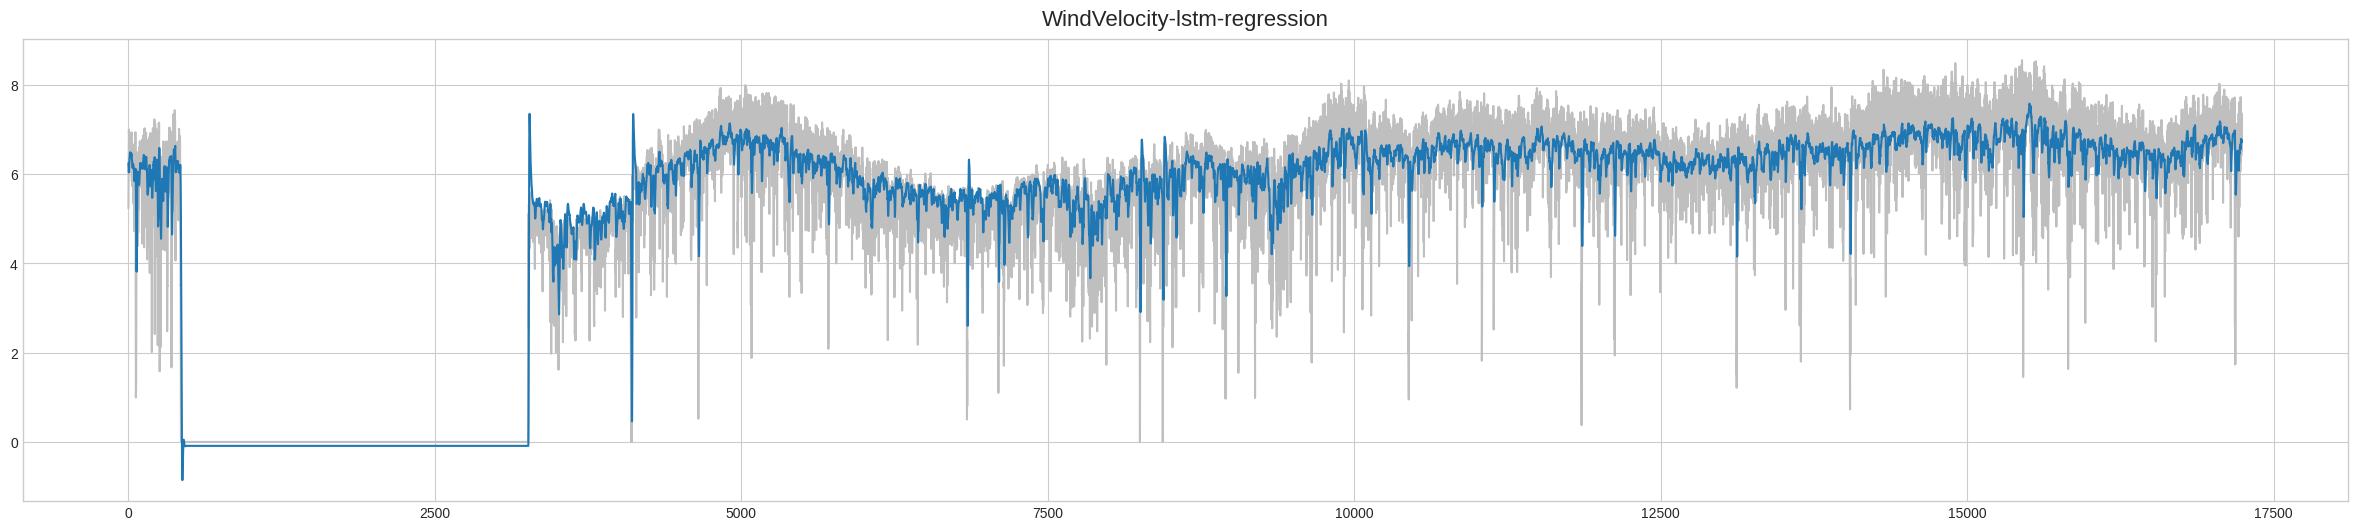

In [6]:
# plot results
plot_params = {"color": "0.75", "style": "-", "legend": False}
test_losses = []
for i in range(len(models)):
    model = models[i]
    # get y_pred
    X_test = X_tests[i]
    y_test = y_tests[i]
    y_pred = model.predict(X_test)

    y_pred = pd.Series(y_pred.reshape((-1,)))
    y_test = pd.Series(y_test.reshape((-1,)))

    y_test.plot(**plot_params)
    y_pred.plot()

    plt.title(model.name)
    post_plot(**plot_kw)

In [7]:
# test losses
# n_test = 1024
test_losses = []
for model, X_test, y_test in zip(models, X_tests, y_tests):
    # X_test, y_test = X_test[-n_test:],y_test[-n_test:]
    test_loss = model.evaluate(X_test, y_test)
    print(f"Mean square error on the test set: {test_loss}")
    test_losses.append(test_loss)

539/539 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - loss: 5.3505e-06
Mean square error on the test set: 3.089625170105137e-05
539/539 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - loss: 4.0656e-04
Mean square error on the test set: 0.000564973393920809
539/539 ━━━━━━━━━━━━━━━━━━━━ 84s 157ms/step - loss: 0.4550
Mean square error on the test set: 0.5262393951416016
